# Exploratory Data Analysis

## New York Time Articles - Data Modeling

### Goal of this notebook

> Train and select best Text Classifier for predicting article subject, `new_desk`, based on its text.

### Data Load

Import libraries.

In [62]:
# visualization and processing packages
import joblib
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm
import matplotlib.pyplot as plt
from src.paths import LOCAL_INTERIM_DATA_PATH, LOCAL_MODELS_PATH

# custom packages for simplifing readibility of current notebook
from src.visualization.Plotter import plot_confusion_matrix
from src.processing.IOController import load_normalized_nyt_df
from src.processing.DataManipulator import get_most_correlated_tokens, predict_text, train_text_classifier, compare_models, plot_prediction_mistakes

# sklearn packages for machine learning / text classifier
from sklearn import metrics
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer

tqdm.pandas()

C:\Users\muril\miniconda3\envs\ds-env\lib\site-packages\tqdm\std.py:668: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


Load consolidated DataFrame.

In [2]:
df = load_normalized_nyt_df(LOCAL_INTERIM_DATA_PATH / 'nyt-articles-consolidated.csv')
df = df.reset_index().drop('index', axis=1)
df.head(2).T

,0,1
abstract,A Times video investigation identified Chinese...,Anger at lockdowns and mask mandates provides ...
web_url,https://www.nytimes.com/2020/07/19/world/asia/...,https://www.nytimes.com/2020/07/19/business/me...
snippet,A Times video investigation identified Chinese...,Anger at lockdowns and mask mandates provides ...
lead_paragraph,As the coronavirus pandemic continues to drive...,"COLUMBUS, Ohio — If you’ve been following Gov...."
source,The New York Times,The New York Times
multimedia,[],"[{'rank': 0, 'subtype': 'xlarge', 'caption': N..."
headline,{'main': 'China Is Using Uighur Labor to Produ...,{'main': 'An Ex-Times Reporter. An Ohio Weddin...
keywords,"[{'name': 'subject', 'value': 'Uighurs (Chines...","[{'name': 'subject', 'value': 'Coronavirus (20..."
pub_date,2020-07-19 20:00:09+00:00,2020-07-20 00:30:07+00:00
document_type,article,article


### Classes Balancing

Remove data with missing `abstract`

> Just noticed there were some missing spots on our target variable, better to get rid of them prior to diving deeper.

In [3]:
df = df[df.abstract.notna()]

Check classes distribution.

> It's important to check the classes distribution before training our model. Usually classes which a predominant tend to bias the classifier. Also, classes which have too few samples tend to be ignored by the model and treated as outliers. The idea here is to avoid overly amplifing or reducing the signal caught from our features and thus minimize biased predictions.

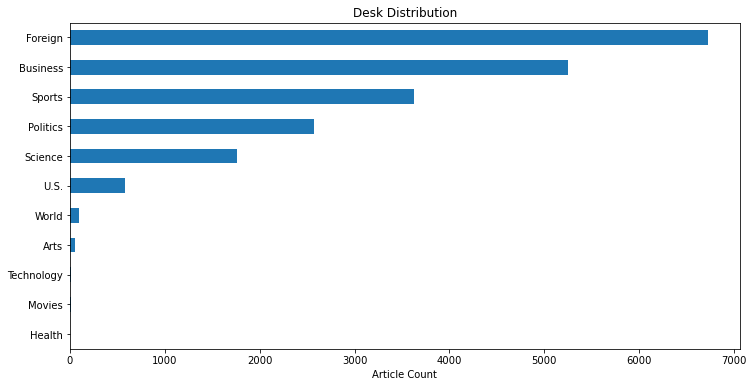

In [4]:
_ = df.news_desk.value_counts(ascending=True).plot(kind='barh', title='Desk Distribution', figsize=(12,6)).set(xlabel='Article Count')

Remove minor classes.

> For simplicity purposes I've just removed everything with sample size lower than 100, since these examples would hardly be predicted anyways. In a real world solution though this has to be checked with the business department and alternatives (such as gathering more data, yahoo!) must be considered. Besides, the Foreign class might be over predicted, and that's something we are going to see further on our confusion matrix!

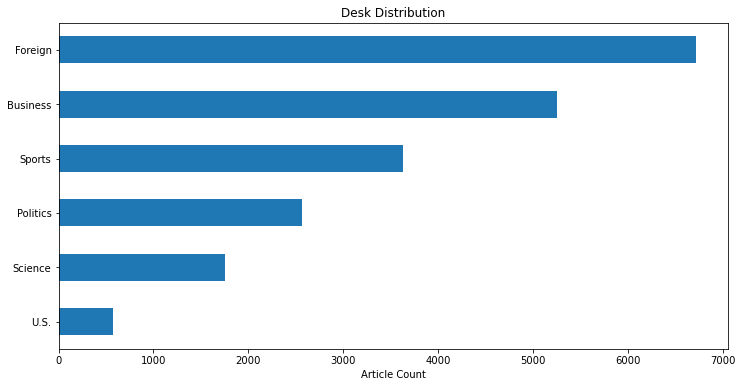

In [5]:
allowed_labels = df.news_desk.value_counts().where(lambda x: x > 100).dropna().index
df = df[df.news_desk.isin(allowed_labels)]
_ = df.news_desk.value_counts(ascending=True).plot(kind='barh', title='Desk Distribution', figsize=(12,6)).set(xlabel='Article Count')

### Feature Engineering

Extract features from text.

> Before training our model we need to convert our text into something the Classifier can actually process. Since we're talking about machines here, nothing better than converting text into numbers! That's exactly what we do here with `TfidfVectorizer`. It follows the bag of words concept, which converts the whole corpus into a words dictionary and each document (or article in this case) gets transformed into a array of numbers signaling which words appeared on the text. This modeling is oversimplified though since it doesn't take into consideration the order of words, only it they happend or not.

In [6]:
df['news_desk_id'] = df.news_desk.factorize()[0]
id_to_news_desk = df.set_index('news_desk_id')['news_desk'].to_dict()
news_desk_to_id = {v: k for k, v in id_to_news_desk.items()}
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=3, norm='l2', encoding='latin-1', ngram_range=(1, 3), stop_words='english')
features = tfidf.fit_transform(df.abstract).toarray()
labels = df.news_desk_id
features.shape

(20508, 18881)

Check Vectorizer result.

> The result features from Vectorizer is a sparse matrix, have a look below. Nice! - There are indeed many zeros there... 

In [81]:
features

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

Check correlation between words and classes.

> Oh how I love statistics! Chi Squared methodology here enabled us to understadt which features (or tokens) have the higher correlation with each class. It's a good indication of how our model might perform when certain keywords appear on the text to predict.

In [7]:
corr_df = get_most_correlated_tokens(features, labels, tfidf, news_desk_to_id, 3)
corr_df.style.set_caption("Most Correlated Tokens to Category")

,1-grams,2-grams,3-grams
Business,"['business', 'companies', 'company']","['real estate', 'commercial real', 'stock market']","['recent commercial real', 'real estate transactions', 'commercial real estate']"
Foreign,"['country', 'prime', 'minister']","['european union', 'benjamin netanyahu', 'prime minister']","['president vladimir putin', 'prime minister benjamin', 'minister benjamin netanyahu']"
Politics,"['sanders', 'democratic', 'biden']","['tip sheet', 'mr biden', 'joe biden']","['democratic presidential candidates', 'joseph biden jr', 'morning tip sheet']"
Science,"['patients', 'study', 'scientists']","['study suggests', 'scientists say', 'new study']","['new study finds', 'food drug administration', 'new study suggests']"
Sports,"['players', 'league', 'team']","['grand slam', 'premier league', 'world cup']","['new england patriots', 'newsletter marc stein', 'week newsletter marc']"
U.S.,"['county', 'detailed', 'maps']","['shows extent', 'asked candidates', 'results maps']","['county map shows', 'extent coronavirus outbreak', 'shows extent coronavirus']"


### Model Selection

Train Naive Bayes classifier.

> Finally we've achieve the moment to actually train a Machine Leraning model!! But let's take it easy hehe... We're starting with a probability classifier which uses the Bayes Theorem. Here it basically compounds each feature probabilty to infer the result considering their combination in a given test value. Let's see it in action!

In [8]:
count_vect, clf = train_text_classifier(df, 'abstract', 'news_desk', MultinomialNB)

Check results.

> After training it we can play around with our first Text Classifier. For that I've taken some article news from NYT web site to see if it actually performs well. And a priori it sure does!

In [9]:
test_texts = [
    "Russian historian jailed in sex abuse case",
    "It’s time for the weirdest season of baseball in recent memory."
]

for txt in test_texts:
    print(predict_text(txt, clf, count_vect))

{'text': 'Russian historian jailed in sex abuse case', 'prediction': 'Foreign'}
{'text': 'It’s time for the weirdest season of baseball in recent memory.', 'prediction': 'Sports'}


### Model Selection

Compare more models.

> Should we be happy with our first trained model? Yes! And how about being satisfied with it? No! Before moving on we should definetly check if our model performs well in comparison to other algorithms. For that we use cross validation. That's what we have below. Apparantly LinearSVC is a good choice.

100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [05:18<00:00, 79.62s/it]


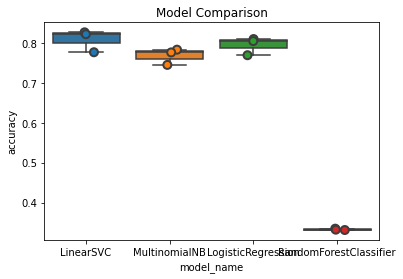

In [12]:
classifiers = [
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0, max_iter=150),
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
]

cv_df = compare_models(classifiers, features, labels, 3)

### Model Evaluation

Evaluate model predictions.

> After choosing the best model, it's a good idea to check how well it performs in a greater detail. The confusion matrix is awesome for that! Here we compare predictions to actual values to check visually the best (and worst) performing classes. It looks like our Foreign class has in fact biased our model, since it has many word predictions specially from Business and Science... Maybe that due to familiar words in both contexts. 

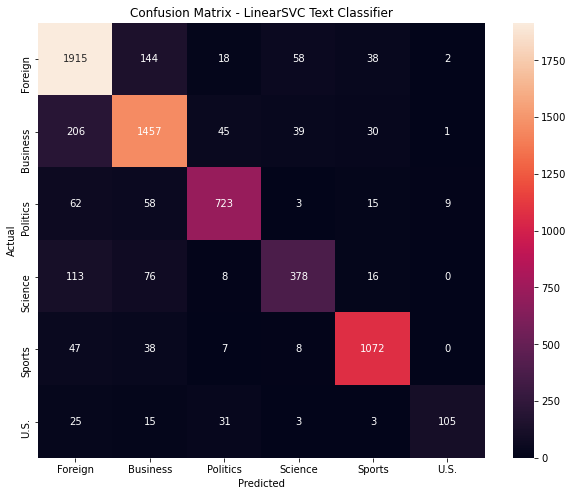

In [59]:
model, c_matrix, y_test, y_pred, indices_test = plot_confusion_matrix(LinearSVC(), df, features, labels, news_desk_to_id)

Check misstakes.

> Here we can have a look on the wrong preditions and indeed some of them are misleading... See that mentions of China nd G-20 inside Business desk, I would personally guess it as Foreign in this case. Anyways, the proper conduct here is to check once again with the business department if these mistakes are acceptable. If not we should go back into gathering more data, choose different models or do hyper parameter tunning for improving it's performance. Nevertheless we're still lacking some hard numbers to tell how well our model performs... Let's have a look at that!

In [60]:
plot_prediction_mistakes(df, y_pred, y_test, id_to_news_desk, c_matrix, indices_test)

'Business' predicted as 'Foreign' : 206 examples.


,news_desk,abstract
8275,Business,All eyes are on a pivotal meeting between President Trump and President Xi Jinping of China at the G-20.
12457,Business,One approach is a microgrid — creating a small power source that can keep the lights on in a small area when the main grid isn’t working.



'Politics' predicted as 'Foreign' : 62 examples.


,news_desk,abstract
9968,Politics,"The Senate majority leader did not back the legislation, but he said the chamber would consider it when lawmakers come back into session next month."
16259,Politics,The 35-day stalemate sapped the president’s poll numbers and raised concern about his ability to navigate a divided government.



'Science' predicted as 'Foreign' : 113 examples.


,news_desk,abstract
16289,Science,"The mysterious Denisovans may have occupied a cave in what is now Siberia for more than 250,000 years."
89,Science,"The country is home to most of the world’s wild tigers, and wildlife authorities announced steps to protect them."



'Sports' predicted as 'Foreign' : 47 examples.


,news_desk,abstract
21079,Sports,"Climbers and the Nepalese government believe the recently exposed bodies are the result of global warming, which is rapidly melting the mountain’s glaciers."
8867,Sports,Police charged the former Yankee and Mets star after a traffic stop last month.



'U.S.' predicted as 'Foreign' : 25 examples.


,news_desk,abstract
3873,U.S.,States that reopened early and relaxed social distancing restrictions may be contributing to the first pronounced increase in Covid-19 fatalities since April.
16546,U.S.,"Every January, thousands of agricultural families come together for a 16-day celebration of Western heritage."



'Foreign' predicted as 'Business' : 144 examples.


,news_desk,abstract
10114,Foreign,"Whoever was responsible, experts say, the episode raised serious concerns about the state of Bulgaria’s cybersecurity."
16175,Foreign,"A year after a dam burst killed at least 259 people, prosecutors accused company executives of covering up safety concerns."



'Politics' predicted as 'Business' : 58 examples.


,news_desk,abstract
10576,Politics,The former investor is an unlikely populist. But he is spending his fortune to try and get money out of politics.
19962,Politics,"Robert Mueller’s letter in March is another sign of anger toward Attorney General William Barr, whose initial statement let President Trump claim to have been vindicated."



'Science' predicted as 'Business' : 76 examples.


,news_desk,abstract
6725,Science,"It’s likely you can, at least for some period of time. That is opening new opportunities for testing and treatment."
1514,Science,This is what happens when atmospheric chemists hang towels on drying racks around their chemistry building.



'Sports' predicted as 'Business' : 38 examples.


,news_desk,abstract
14599,Sports,"After forcing his way out of Miami, Minkah Fitzpatrick has powered the Steelers’ surprising surge into contention."
5153,Sports,A forensic audit of Russia’s antidoping agency has suggested former officials funneled money to companies they controlled.



'U.S.' predicted as 'Business' : 15 examples.


,news_desk,abstract
1227,U.S.,"More than 300 dams in the state are classified as having the potential to cause loss of life or economic and environmental damage in the case of a failure, according to the U.S. Army Corps of Engineers."
11628,U.S.,"Mass shootings came one after another, sometimes only hours apart, leaving a reeling nation wondering why."



'Foreign' predicted as 'Politics' : 18 examples.


,news_desk,abstract
821,Foreign,"Chen Chien-jen has embraced a rare dual role, using his political authority as vice president to criticize China’s response to the virus even as he hunkers down to analyze trends in transmission."
8550,Foreign,"Mr. Sigley, whose family raised alarms last week after losing contact with him, declined to say on Thursday why he had been detained."



'Business' predicted as 'Politics' : 45 examples.


,news_desk,abstract
12643,Business,Several candidates criticized Senator Elizabeth Warren’s health care proposal and backed proposals to impose big taxes on the wealthy.
14677,Business,A coal town in southwestern Virginia has been trying for years. Hope is running thin.



'U.S.' predicted as 'Politics' : 31 examples.


,news_desk,abstract
15997,U.S.,Senators Elizabeth Warren and Bernie Sanders led the stage of six candidates.
9615,U.S.,See which candidates spoke the most and which candidates disagreed over policy.



'Foreign' predicted as 'Science' : 58 examples.


,news_desk,abstract
12140,Foreign,"Zarifa Ghafari expects to die in office. But in the meantime, she intends to do something about the litter problem."
2259,Foreign,"He caught a break this week, flustering his Labour opponent in Parliament and glorying in British researchers’ discovery of an effective treatment drug against Covid-19 symptoms."



'Business' predicted as 'Science' : 39 examples.


,news_desk,abstract
8305,Business,"A survey finds that voters think the trade measures will be bad for the United States, and that even most Republicans say they will lead to higher prices."
4833,Business,"The Dart Container Corporation, which makes foam products, is a manufacturing behemoth and produced a fortune for the family behind it. Environmentalists say its products are polluting the globe."



'Foreign' predicted as 'Sports' : 38 examples.


,news_desk,abstract
14658,Foreign,A headline alongside photos of two black players in the Corriere dello Sport brought new condemnations of racism in Italy. The newspaper said it had suffered a “lynching.”
5071,Foreign,"Fast on the heels of another big storm, Dennis has caused flooding and misery for the second straight weekend."



'Business' predicted as 'Sports' : 30 examples.


,news_desk,abstract
16189,Business,"Ford Motor is transforming the long-vacant Michigan Central Station, part of the city’s overall resurgence."
3161,Business,"Put through its paces on a motor club’s racetrack, the 2021 Porsche 911 Turbo S growls with a gaudy 640 horsepower and handling that lets even amateur drivers feel like superheroes."



'Politics' predicted as 'Sports' : 15 examples.


,news_desk,abstract
5453,Politics,Getting into one of the Democratic debates is like getting a ticket to the Super Bowl or the World Series.
1118,Politics,He isn’t yet the pop culture star that Ruth Bader Ginsburg — “Notorious R.B.G.” to many — is. But his fans think he could be.



'Science' predicted as 'Sports' : 16 examples.


,news_desk,abstract
9184,Science,"On Sunday night, The Times presents a play, built from the words of the men and women who made the Apollo missions happen."
9233,Science,"Even when older plaintiffs win their suits, correcting institutional biases can take years."


Check classification report.

> Last step is to calculate the model metrics, here it's possible to check precision (false positive rate), recall (false negative rate), f1-score (harmonic mean of precision and recall) and accuracy (true predicitions divided by all observations) for each class. It looks like the model performs fairly well with 83% accuracy in average, though there are some weak points at Science desk (with lowess precision and second lowest recall), and US as well (lowest recall). Maybe it's time to gather more data for these specific fields, or check if they are necessary at well (again with the business felows!).

In [63]:
print(metrics.classification_report(y_test, y_pred, target_names=df['news_desk'].unique()))

              precision    recall  f1-score   support

     Foreign       0.81      0.88      0.84      2175
    Business       0.81      0.82      0.82      1778
    Politics       0.87      0.83      0.85       870
     Science       0.77      0.64      0.70       591
      Sports       0.91      0.91      0.91      1172
        U.S.       0.90      0.58      0.70       182

    accuracy                           0.83      6768
   macro avg       0.85      0.78      0.80      6768
weighted avg       0.84      0.83      0.83      6768



### Model Export

Export data.

> Exporting models for later reproduction is a must! Specially here since we're gonna wrap it inside an API so it can be available on an endpoint. 

In [96]:
joblib.dump(model, LOCAL_MODELS_PATH / 'model.sav')
joblib.dump(tfidf, LOCAL_MODELS_PATH / 'tfidf.sav')
joblib.dump(id_to_news_desk, LOCAL_MODELS_PATH / 'id_to_news_desk.sav')

['c:\\users\\muril\\documents\\github\\newspapers-text-mining\\models\\id_to_news_desk.sav']